# VarClump3D: Concept test on Orion

In [1]:
%matplotlib inline

import sys
import numba
import time
import numpy as np
import numpy.ma as ma
import scipy as sp
import sympy as sym
import numexpr as ne
from math import exp, sqrt, log, floor, ceil
from threading import Thread
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact, interactive, fixed

#from mayavi import mlab

# VarClump functions
sys.path.append('../lib/')
from points_generation import *
from graph import *

# acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import load_fits, standarize

# extra metric module#
#import custom_metric as cm

## Helpers computing functions

In [2]:
def estimate_rms(data):
    """
    Computes RMS value of N-dimensional numpy array
    """

    if isinstance(data, ma.MaskedArray):
        ret = np.sum(data*data) / (np.size(data) - np.sum(data.mask)) 
    else: 
        ret = np.sum(data*data) / np.size(data)
    return np.sqrt(ret)


def estimate_entropy(data):
    """
    Computes Entropy of N-dimensional numpy array
    """

    # estimation of probabilities
    p = np.histogram(data.ravel(), bins=256, density=False)[0].astype(float)
    # little fix for freq=0 cases
    p = (p+1.)/(p.sum()+256.)
    # computation of entropy 
    return -np.sum(p * np.log2(p))


def estimate_variance(data):
    """
    Computes variance of N-dimensional numpy array
    """

    return np.std(data)**2


def compute_residual_stats(data, xc, yc, zc, c, sig, base_level=0., square_c=True, compact_supp=True):
    """
    Computes the residual stats between appproximation and real data
    """
    dims = data.shape
    _xe = np.linspace(0., 1., dims[0]+2)[1:-1]
    _ye = np.linspace(0., 1., dims[1]+2)[1:-1]
    _ze = np.linspace(0., 1., dims[2]+2)[1:-1]
    Xe,Ye,Ze = np.meshgrid(_xe, _ye, _ze, indexing='ij', sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel(); ze = Ze.ravel()
    
    if square_c: c = c**2
    u = u_eval(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001) + base_level
    u = u.reshape(dims)
    
    residual = data-u
    
    return (estimate_variance(residual), 
            estimate_entropy(residual),
            estimate_rms(residual))

## Helpers visualization functions

In [3]:
"""
Helper function to visualize the quality of the solution
"""

def slices_plot(data, slc):
    plt.figure(figsize=(5,5))
    im = plt.imshow(data[slc], vmin=0, vmax=1.)
    plt.title('3D cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
def comparative_slices_plot(data1, data2, slc):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    im = plt.imshow(data1[slc], vmin=0, vmax=1.)
    plt.title('3D original cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.subplot(1,2,2)
    im = plt.imshow(data2[slc], vmin=0, vmax=1.)
    plt.title('3D approximated cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
@numba.jit('float64[:] (float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64, float64)', nopython=True)
def _compute_solution(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            if (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2 > supp**2 * sig[j]**2: continue
            ret[i] += c[j] * exp( -( (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2 ) / (2* (sig0**2 + sig[j]**2) ) )
    return ret

def compute_solution(c, sig, xc, yc, zc, dims, base_level=0., square_c=True, resolution=1):
    _xe = np.linspace(0., 1., resolution*dims[0]+2)[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1]+2)[1:-1]
    _ze = np.linspace(0., 1., resolution*dims[2]+2)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye); len_ze = len(_ze)
    Xe,Ye,Ze = np.meshgrid(_xe, _ye, _ze, indexing='ij', sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel(); ze = Ze.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    if square_c: c = c**2
    u = _compute_solution(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001) + base_level
    return u.reshape(len_xe, len_ye, len_ze)


@numba.jit('float64[:] (float64[:], float64[:], float64[:], float64[:], float64[:], \
           float64[:], float64[:], float64[:], float64, float64)', nopython=True, nogil=True)
def u_eval(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2
            if  dist2 > supp**2 * sig[j]**2: continue
            ret[i] += c[j] * exp( -dist2 / (2* (sig0**2 + sig[j]**2)) )
    return ret

In [4]:
# %timeit u_eval(c0, sig0, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001)

In [5]:
# @numba.jit('void (float64[:], float64[:], float64[:,:], float64[:,:], int64, int64, \
#            float64[:], float64, float64)', nopython=True, nogil=True)
# def u_eval(c, sig, epoints, cpoints, start, chunk_size, ret, supp=5., sig0=0.001):
#     m = len(epoints)
#     n = len(cpoints)
#     for i in range(start, min(start+chunk_size, m)):
#         for j in range(n):
#             dist2 = np.sum((epoints[i] - cpoints[i])**2)
#             if  dist2 > supp**2 * sig[j]**2: continue
#             ret[i] += c[j] * exp( -dist2 / (2* (sig0**2 + sig[j]**2)) )

# def thread_eval(c, sig, epoints, cpoints, n_thread=2):
#     chunk_size = len(epoints)/n_thread
    
#     ret = np.zeros(len(epoints))
    
#     start_index = [i*chunk_size for i in range(n_thread)]
    
#     threads = [Thread(target=u_eval, args=(c, sig, epoints, cpoints, start, chunk_size, ret, 5, 0.001)) for start in start_index]
    
#     for thread in threads:
#         thread.start()
#     for thread in threads:
#         thread.join()
    
#     return ret

In [6]:
# %timeit thread_eval(c0, sig0, collocation_points, center_points)

## Loading 3D data

In [7]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'

def load_data(fit_path):
    container = load_fits(fit_path)
    data = standarize(container.primary)[0]
    data = data.data

    # map to [0,1] range
    data -= data.min()
    data /= data.max()

    # generating the data function
    x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
    z = np.linspace(0., 1., data.shape[2]+2, endpoint=True)[1:-1]
    _dfunc = RegularGridInterpolator((x, y, z), data, method='linear', bounds_error=False, fill_value=0.)
    
#     def dfunc(points):
#         if points.ndim==1:
#             return _dfunc([[points[2],points[0],points[1]]])
#         elif points.ndim==2:
#             return _dfunc(points)
#             #return  _dfunc(np.roll(points, -1, axis=1))
    
    return x, y, z, data, _dfunc

x, y, z, data, dfunc = load_data(fit_path)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


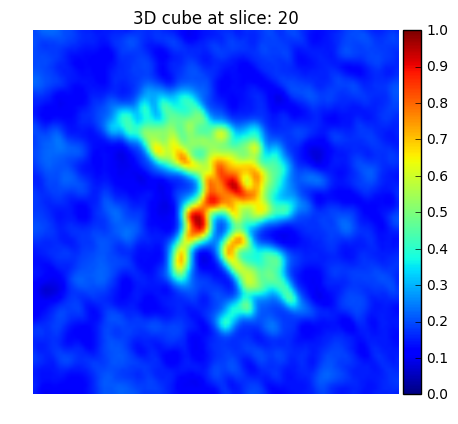

<function __main__.slices_plot>

In [8]:
interact(slices_plot, data=fixed(data), slc=(0, data.shape[0]-1))

In [9]:
#mlab.contour3d(data, contours=4, transparent=True)

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^3} L(x, y, z, u, u_x, u_y, u_z) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^3}(u(x,y,z)-f_0(x,y,z))^2 + \alpha \ \Psi_1(u(x,y,z)-f_0(x,y,z)) + \beta \ \Psi_2(\left|\nabla u(x,y,z)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y} -  \frac{d}{dz}\frac{\partial L}{\partial u_z}= 0$$

**2D case**:
$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

**3D case**:
$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y,z) = \sum_{i=1}^N c_i \ \phi(x, y, z;\ x_i, y_i, z_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$ (they will be the same)

In [10]:
"""
General Psi penalizing function (applicable in both cases)
"""
def psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('10*x**3 - 15*x**4 + 6*x**5')
    return ret

def d1psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('30*x**2 - 60*x**3 + 30*x**4')
    return lamb*ret

def d2psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('60*x - 180*x**2 + 120*x**3')
    return (lamb**2)*ret

## $\phi$-RBF function to use and its derivatives

In [11]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2)))')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2)] = 0.
    return retval

def phix(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * x')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * y')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * z')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phixx(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiyy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (y**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phizz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (z**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phiyx
def phixy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x*y)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phizx
def phixz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x*z)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phizy
def phiyz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (y*z)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

## Euler-Lagrange function class definition

In [12]:
"""
Euler-Lagrange class definition
"""
class ELModel():
    def __init__(self, data, dfunc, dims, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, d1psi1=None, d1psi2=None, d2psi2=None,
                 a=0., b=0., lamb1=1., lamb2=1., base_level=0, square_c=True, pix_freedom=1., compact_supp=False):
        f0 = dfunc( np.vstack([xe,ye,ze]).T )
        fb = dfunc( np.vstack([xb,yb,zb]).T )
        #f0 = np.array([dfunc([xe[i],ye[i],ze[i]]) for i in range(len(xe))]).ravel()
        #fb = np.array([dfunc([xb[i],yb[i],zb[i]]) for i in range(len(xb))]).ravel()
        len_f0 = len(f0)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        Ne = len(xe)
        Nc = len(xc)
        Nb = len(xb)
        
        """
        Storing important atributes
        """
        self.data = data
        self.dfunc = dfunc
        self.f0 = f0
        self.fb = fb
        self.xb = xb; self.yb = yb; self.zb = zb
        self.xe = xe; self.ye = ye; self.ze = ze
        self.xc = xc; self.yc = yc; self.zc = zc
        self.xc0 = xc; self.yc0 = yc; self.zc0 = zc
        self.theta_xc = np.zeros(Nc)
        self.theta_yc = np.zeros(Nc)
        self.theta_zc = np.zeros(Nc)
        self.deltax = pix_freedom * 1./dims[0]
        self.deltay = pix_freedom * 1./dims[1]
        self.deltaz = pix_freedom * 1./dims[2]
        self.c = c0
        self.sig = sig0
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.base_level = base_level
        self.square_c = square_c
        self.compact_supp = compact_supp

        
    def set_centers(self, theta_xc, theta_yc, theta_zc):        
        self.xc = self.xc0 + self.deltax * np.sin(theta_xc)
        self.yc = self.yc0 + self.deltay * np.sin(theta_yc)
        self.zc = self.zc0 + self.deltaz * np.sin(theta_zc)
    
    
    def set_theta(self, theta_xc, theta_yc, theta_zc):
        self.theta_xc = theta_xc
        self.theta_yc = theta_yc
        self.theta_zc = theta_zc
      
    
    def set_c(self, c):
        self.c = c

        
    def set_sig(self, sig):
        self.sig = sig
    
    
    def set_params(self, params):
        N = len(params)/5
        self.theta_xc = params[0:N]
        self.theta_yc = params[N:2*N]
        self.theta_zc = params[2*N:3*N]
        self.c = params[3*N:4*N]
        self.sig = params[4*N:5*N]

    
    def get_params(self):
        return np.concatenate([self.theta_xc, self.theta_yc, self.theta_zc, self.c, self.sig])
    
        
    def F(self, params):
        N = len(params)/5
        theta_xc = params[0:N]
        theta_yc = params[N:2*N]
        theta_zc = params[2*N:3*N]
        
        xc = self.xc0 + self.deltax * np.sin(theta_xc)
        yc = self.yc0 + self.deltay * np.sin(theta_yc)
        zc = self.zc0 + self.deltaz * np.sin(theta_zc)
        
        xe = self.xe; ye = self.ye; ze = self.ze
        
        if self.square_c: c = params[3*N:4*N]**2
        else: c = params[3*N:4*N]
        sig = params[4*N:5*N]
    
        
        # computing u, ux, uy, ...
        u = u_eval(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001) + self.base_level
        el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        return el

$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

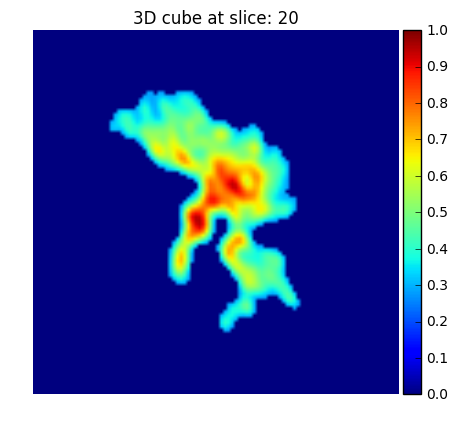

<function __main__.slices_plot>

In [13]:
base_level = 1.5*estimate_rms(data)
_data = np.copy(data)
mask = data > base_level
_data[~mask] = 0. 
interact(slices_plot, data=fixed(_data), slc=(0, _data.shape[0]-1))

In [14]:
def _inv_gaussian_kernel(kernlen=3, sig=0.1):
    """
    Returns a 2D Gaussian kernel array.
    """
    interval = (2*sig+1.)/(kernlen)
    x = np.linspace(-sig-interval/2., sig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel.max()-kernel

def random_centers_generation(data, n_centers, base_level=None, power=5.):
    # fixed seed
    np.random.seed(0)
    
    data = np.copy(data)
    
    # unusable pixels mask
    if base_level is not None:
        mask = data <= base_level
        if np.sum(~mask) < n_centers:
            print('The number of usable pixels is less than n_centers')
            return None
        
    # applying power and re-normalizing
    data **= power
    data /= data.max()

    # data dimensions
    l,m,n = data.shape
    
    # center points positions
    x = np.linspace(0., 1., l+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., m+2, endpoint=True)[1:-1]
    z = np.linspace(0., 1., n+2, endpoint=True)[1:-1]
    X,Y,Z = np.meshgrid(x,y,z, indexing='ij')
    points_positions = np.vstack( [ X.ravel(), Y.ravel(), Z.ravel() ]).T
    
    # array with indexes of such centers
    points_indexes = np.arange(0, points_positions.shape[0], dtype=int)
    
    # array with probabilities of selection for each center
    if isinstance(mask, np.ndarray):
        data[mask] = 0.
        prob = data/data.sum()
    else:
        prob = data/data.sum()
    
    # convolution kernel
    #K = np.array([[0.5, 0.5, 0.5], [0.5, 0., 0.5], [0.5, 0.5, 0.5]])
    #K = _inv_gaussian_kernel(kernlen=3, sig=3.)
    
    selected = []
    while len(selected)!=n_centers:
        sel = np.random.choice(points_indexes, size=1 , p=prob.ravel(), replace=False)[0]
        # border pixels can't be selected
        index0 = sel / (m*n)
        index1 = (sel/ n) % m 
        index2 = sel % n
        if index0==0 or index0==l-1 or index1==0 or index1==m-1 or index2==0 or index2==n-1: continue
        selected.append(sel)
        # update the pixel probabilities array
        #prob[index0-1:index0+2, index1-1:index1+2] *= K
        prob[index0-1:index0+2, index1-1:index1+2, index2-1:index2+2] *= 0.5
        prob[index0, index1, index2] *= 0.
        prob /= prob.sum()
        
    return points_positions[selected]

In [15]:
# number of points of each type
Nb = 0
Nc = 500
Ne = 5*Nc-4*Nb

In [16]:
base_level = 1.5*estimate_rms(data)

##########################################
# Approach 1
##########################################

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)


##########################################
# Approach 2
##########################################

# collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
# center_points = collocation_points[0:Nc]
# boundary_points = boundary_generation(Nb)



##########################################
# Approach 3
##########################################

# points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=3)
# center_points = points[0:Nc]
# collocation_points = points[Nc:Nc+Ne]
# boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

### Visualization of points

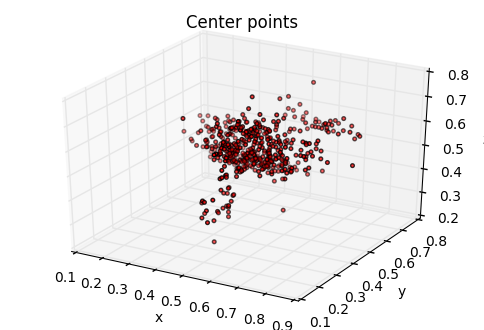

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

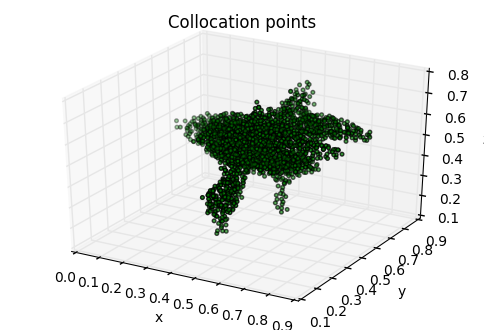

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()

## Initial Conditions

In [19]:
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

In [20]:
def estimate_initial_guess(center_points, dist_matrix, dfunc, R=0.05, minsig=0.001, method='min_dist'):
    m = center_points.shape[0]
    c_arr = np.empty(m, dtype=float)
    sig_arr = np.empty(m, dtype=float)
    
    if method=='mean_dist':
        f = 1./sqrt(log(2.))
        mean_dist = np.zeros(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)   
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                #dont take into account points outside R radius
                if d>R: continue
                num_neigh[i] += 1
                mean_dist[i] += d
            """
            Key Idea: The mean distance to neighbors acurrs when the
            gaussian function has decayed to the half
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(center_points[i])[0]
                sig_arr[i] = minsig
            else:
                mean_dist[i] /= num_neigh[i]
                c_arr[i] = dfunc(center_points[i])[0]/num_neigh[i]
                #c_arr[i] = dfunc(center_points[i])[0]*mean_dist[i]**2
                sig_arr[i] = f*mean_dist[i]
                
    elif method=='min_dist':
        min_dist = np.inf*np.ones(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)
        #first we find the distance to the nearest neighbor
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d<min_dist[i]: min_dist[i] = d
        #second, we find the number of neighbors on the neighborhood
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d > 3*min_dist[i]: continue
                num_neigh[i] += 1
            """
            some explanation here
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(center_points[i])[0]
                sig_arr[i] = minsig
            else:
                c_arr[i] = dfunc(center_points[i])[0]/(num_neigh[i]+1)
                sig_arr[i] = min_dist[i] 
    return (c_arr,sig_arr)

In [21]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, method='min_dist')
#c0 = 0.01 * np.ones(Nc)
#sig0 = 0.05 * np.ones(Nc)

In [22]:
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)

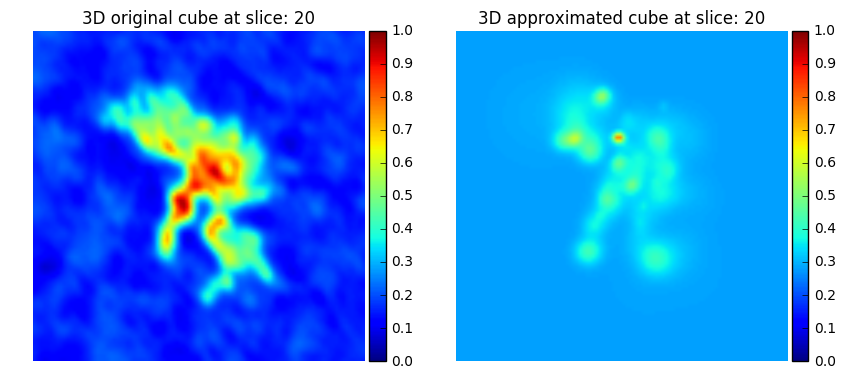

<function __main__.comparative_slices_plot>

In [23]:
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

## Visualizing the initial solution

In [24]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
#plot_sol(c0, sig0, xc, yc, base_level=0., compact_supp=False)
#params_plot(c0, sig0, xc, yc, square_c=True)
#params_distribution_plot(c0, sig0, square_c=True)

# Experiments

In [29]:
def elm_solver(elm, method='iterative', n_iter=5, verbose=True, base_level=0., 
              square_c=True, compact_supp=False, max_iter=100000, step_iter=None):
    t0 = time.time()
    
    if step_iter is None:
        step_iter = int(max_iter/10)

    if method=='exact':
        residual_variance = []
        residual_entropy = []
        residual_rms = []
        iter_list = range(step_iter, max_iter+1, step_iter)
        
        for it in iter_list:
            print('\n'+'#'*90)
            print('Results after {0} iterations'.format(it))
            print('#'*90)
            # lm optimization
            sol = sp.optimize.root(elm.F, elm.get_params(), method='lm', options={'maxiter':step_iter})
            sol_length = len(sol.x)/5
            opt_theta_xc = sol.x[0:sol_length]
            opt_theta_yc = sol.x[sol_length:2*sol_length]
            opt_theta_zc = sol.x[2*sol_length:3*sol_length]
            opt_c = sol.x[3*sol_length:4*sol_length]
            opt_sig = sol.x[4*sol_length:5*sol_length]
            
            old_xc = elm.xc
            old_yc = elm.yc
            old_zc = elm.zc
            new_xc = elm.xc0 + elm.deltax * np.sin(opt_theta_xc)
            new_yc = elm.yc0 + elm.deltay * np.sin(opt_theta_yc)
            new_zc = elm.zc0 + elm.deltaz * np.sin(opt_theta_zc)
            
            # variation of centers, c and sig
            delta_theta_xc = np.linalg.norm(opt_theta_xc-elm.theta_xc)
            delta_theta_yc = np.linalg.norm(opt_theta_yc-elm.theta_yc)
            delta_theta_zc = np.linalg.norm(opt_theta_zc-elm.theta_zc)
            delta_xc = np.linalg.norm(new_xc-old_xc)
            delta_yc = np.linalg.norm(new_yc-old_yc)
            delta_zc = np.linalg.norm(new_zc-old_zc)
            delta_c = np.linalg.norm(opt_c-elm.c)
            delta_sig = np.linalg.norm(opt_sig-elm.sig)
            
#             # searching for noisy gaussians (and removing them)
#             mask = np.abs(opt_sig)<1.
#             if np.any(~mask):
#                 print('{0} noisy gaussians detected and removed! \n'.format(np.sum(~mask)))
#                 opt_xc = opt_xc[mask]
#                 opt_yc = opt_yc[mask]
#                 opt_zc = opt_zc[mask]
#                 opt_c = opt_c[mask]
#                 opt_sig = opt_sig[mask]
                
            
            # update of best parameters
            elm.set_theta(opt_theta_xc, opt_theta_yc, opt_theta_zc)
            elm.set_centers(opt_theta_xc, opt_theta_yc, opt_theta_zc)
            elm.set_c(opt_c)
            elm.set_sig(opt_sig)
            
            # residual stats
            var,entr,rms = compute_residual_stats(elm.data, elm.xc, elm.yc, elm.zc, elm.c, elm.sig, 
                           base_level=elm.base_level, square_c=elm.square_c, compact_supp=elm.compact_supp)
            
            # appending residual variance, entropy and rms
            residual_variance.append(var)
            residual_entropy.append(entr)
            residual_rms.append(rms)
            
            print('Variation on theta_xc = {0}'.format(delta_theta_xc))
            print('Variation on theta_yc = {0}'.format(delta_theta_yc))
            print('Variation on theta_zc = {0}'.format(delta_theta_zc))
            print('Variation on xc = {0}'.format(delta_xc))
            print('Variation on yc = {0}'.format(delta_yc))
            print('Variation on zc = {0}'.format(delta_zc))
            print('Variation on c = {0}'.format(delta_c))
            print('variation on sig = {0}'.format(delta_sig))
            print('\nsuccess: {0}'.format(sol['success']))
            print('\nstatus: {0}'.format(sol['status']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nnfev: {0}'.format(sol['nfev']))
            if sol['success']: break
        
        print('\n \n' + '#'*90)    
        print('FINAL RESULTS:')
        print('#'*90)  

        print('Residual RMS: {0}'.format(residual_rms[-1]))
        print('Residual Variance: {0}'.format(residual_variance[-1]))
        print('Residual Entropy: {0}'.format(residual_entropy[-1]))
        print('Total elapsed time: {0} [s]'.format(time.time()-t0))
        
        # plots generation
        # solution_plot(elm.dfunc, opt_c, opt_sig, elm.xc, elm.yc, base_level=base_level, square_c=square_c, compact_supp=compact_supp)
        # params_plot(elm.c, elm.sig, elm.xc, elm.yc, square_c=square_c)
        # params_distribution_plot(elm.c, elm.sig, square_c=square_c)
        residual_plot(residual_variance, residual_entropy, residual_rms, iter_list[0:len(residual_rms)])

## Experiments 1: Random sampled Gaussian centers
The following instances test with different settings combinations for the number of centers

## `500 centers`

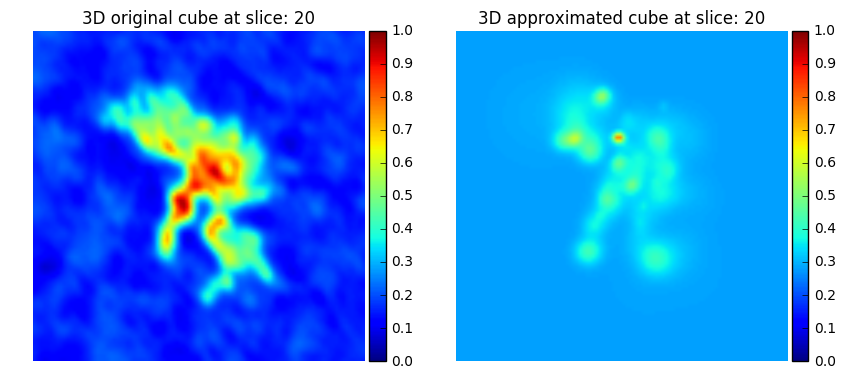


##########################################################################################
Results after 10000 iterations
##########################################################################################
Variation on theta_xc = 61.6137759403
Variation on theta_yc = 77.9069368691
Variation on theta_zc = 133.03419376
Variation on xc = 0.253327894184
Variation on yc = 0.156529853389
Variation on zc = 0.156535887631
Variation on c = 1.31896052484
variation on sig = 0.211467322888

success: False

status: 5

message: Number of calls to function has reached maxfev = 10000.

nfev: 10008

##########################################################################################
Results after 20000 iterations
##########################################################################################
Variation on theta_xc = 0.801730992079
Variation on theta_yc = 1.78836726655
Variation on theta_zc = 1.66933497277
Variation on xc = 0.00460160020685
Variation on yc = 0.00714007508573
Vari

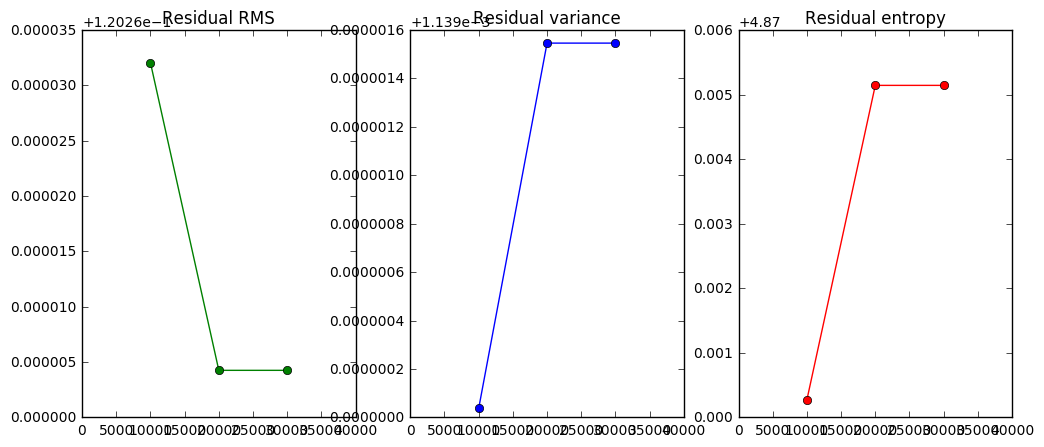

In [30]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 500
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm01 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True, pix_freedom=1)

elm_solver(elm01, method='exact', base_level=base_level, square_c=True, max_iter=100000)

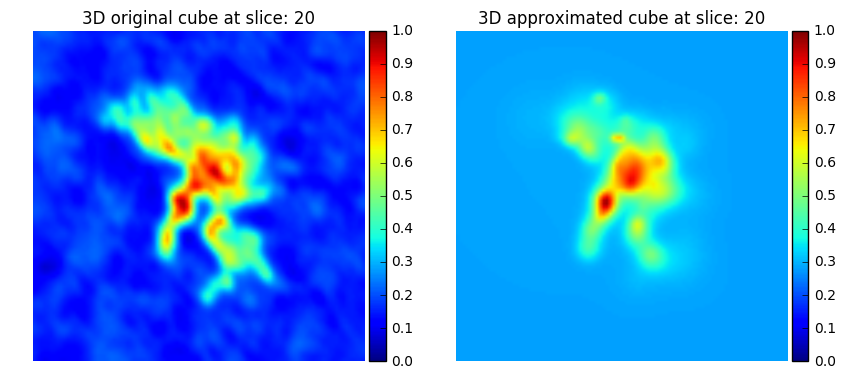

<function __main__.comparative_slices_plot>

In [31]:
# visualization of solution
u_sol = compute_solution(elm01.c, elm01.sig, elm01.xc, elm01.yc, elm01.zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `1000 centers`

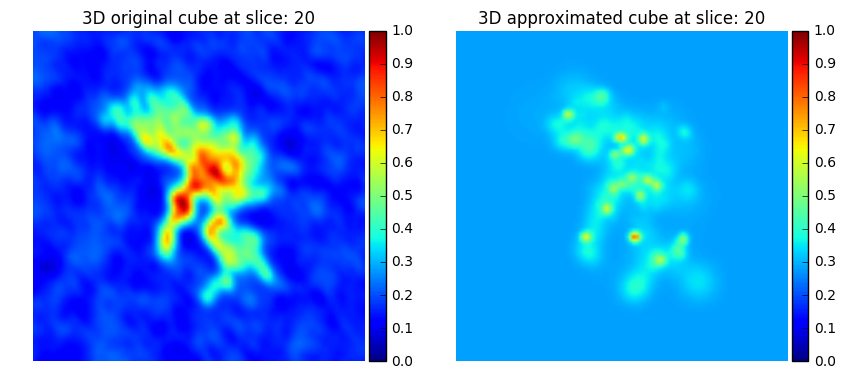


##########################################################################################
Results after 10000 iterations
##########################################################################################
Variation on theta_xc = 44.5329277818
Variation on theta_yc = 96.1132294468
Variation on theta_zc = 102.678305609
Variation on xc = 0.154843398286
Variation on yc = 0.135109202731
Variation on zc = 0.141960474643
Variation on c = 0.734250673878
variation on sig = 0.433292706594

success: False

status: 5

message: Number of calls to function has reached maxfev = 10000.

nfev: 10006

##########################################################################################
Results after 20000 iterations
##########################################################################################
Variation on theta_xc = 265.657326341
Variation on theta_yc = 2187.84050729
Variation on theta_zc = 1930.5067462
Variation on xc = 0.265292863826
Variation on yc = 0.18770399556
Variation

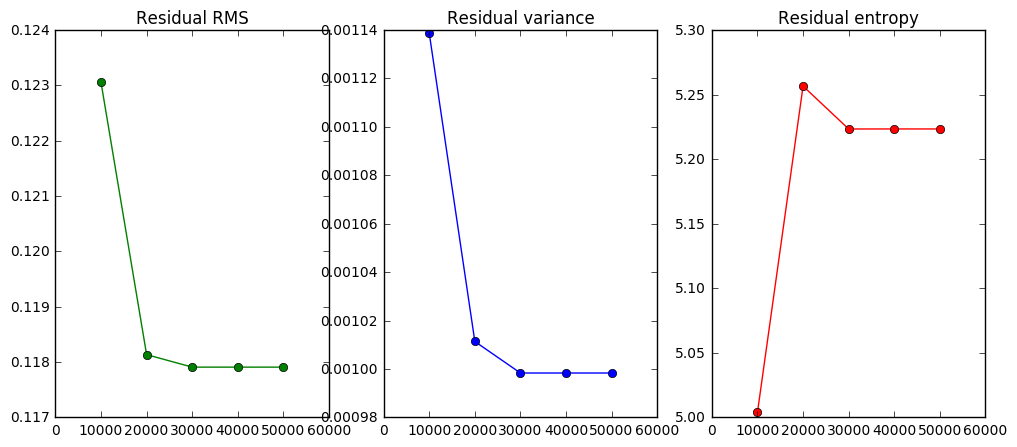

In [32]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 1000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm02 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True, pix_freedom=1)

elm_solver(elm02, method='exact', base_level=base_level, square_c=True, max_iter=100000)

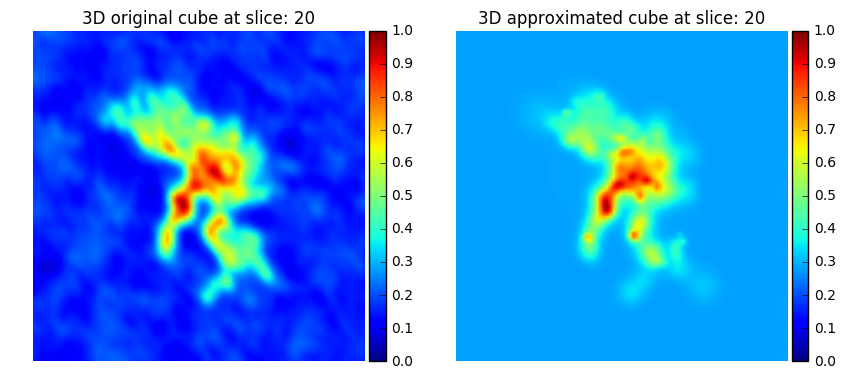

<function __main__.comparative_slices_plot>

In [ ]:
# visualization of solution
u_sol = compute_solution(elm02.c, elm02.sig, elm02.xc, elm02.yc, elm02.zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `2000 centers`

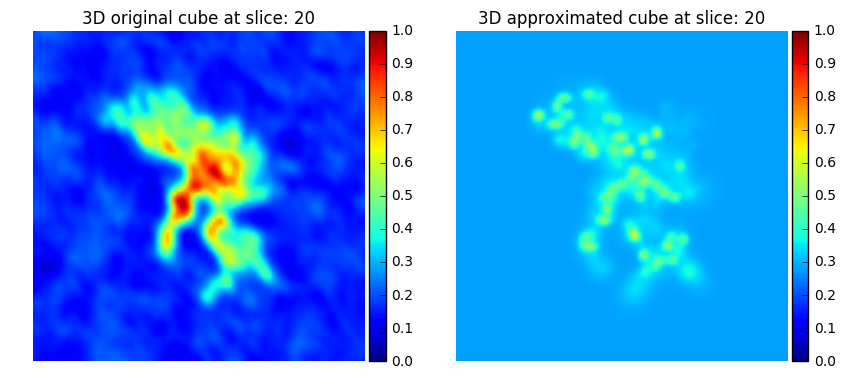


##########################################################################################
Results after 10000 iterations
##########################################################################################
Variation on theta_xc = 0.0
Variation on theta_yc = 0.0
Variation on theta_zc = 0.0
Variation on xc = 0.0
Variation on yc = 0.0
Variation on zc = 0.0
Variation on c = 0.0
variation on sig = 0.0

success: False

status: 5

message: Number of calls to function has reached maxfev = 10000.

nfev: 10002

##########################################################################################
Results after 20000 iterations
##########################################################################################


In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 2000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm03 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True, pix_freedom=1)

elm_solver(elm03, method='exact', base_level=base_level, square_c=True, max_iter=100000)

In [ ]:
# visualization of solution
u_sol = compute_solution(elm03.c, elm03.sig, elm03.xc, elm03.yc, elm03.zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `3000 centers`

In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 3000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm04 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True, pix_freedom=1)

elm_solver(elm04, method='exact', base_level=base_level, square_c=True, max_iter=100000)

In [ ]:
# visualization of solution
u_sol = compute_solution(elm04.c, elm04.sig, elm04.xc, elm04.yc, elm04.zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `4000 centers`

In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 4000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(np.sqrt(c0), sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm05 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True, pix_freedom=1)

elm_solver(elm05, method='exact', base_level=base_level, square_c=True, max_iter=100000)

In [ ]:
# visualization of solution
u_sol = compute_solution(elm05.c, elm05.sig, elm05.xc, elm05.yc, elm05.zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))